In [113]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [114]:
data = pd.read_csv('/content/drive/MyDrive/nn_train (1).csv')
data

,ID,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_1017,Feature_1018,Feature_1019,Feature_1020,Feature_1021,Feature_1022,Feature_1023,Feature_1024,binary_label,class_label
0,1,81,109,91,96,107,97,103,95,100,...,114,93,91,98,72,92,78,78,0,5
1,2,168,168,169,169,170,171,172,172,175,...,44,44,44,44,44,44,44,44,0,9
2,3,14,20,32,6,27,6,5,34,15,...,63,64,63,60,54,48,43,41,0,5
3,4,60,109,157,126,82,80,70,58,37,...,105,102,99,98,100,105,111,114,1,8
4,5,63,72,86,75,93,77,75,67,62,...,108,109,102,106,96,91,102,89,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,79996,58,72,90,89,73,68,68,59,61,...,11,8,5,3,3,2,1,0,1,1
79996,79997,245,232,245,255,255,255,252,250,251,...,39,36,37,37,38,42,46,54,1,10
79997,79998,9,39,48,50,75,104,133,164,184,...,0,0,9,0,7,16,9,24,0,2
79998,79999,116,180,214,212,216,219,215,218,221,...,66,75,70,67,66,86,54,77,0,10


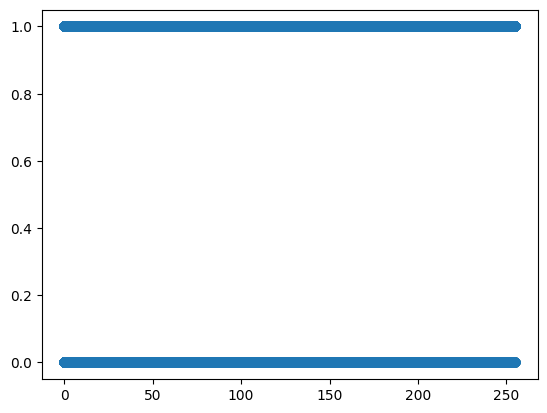

In [115]:
plt.scatter(data.Feature_1,data.binary_label)
plt.show()

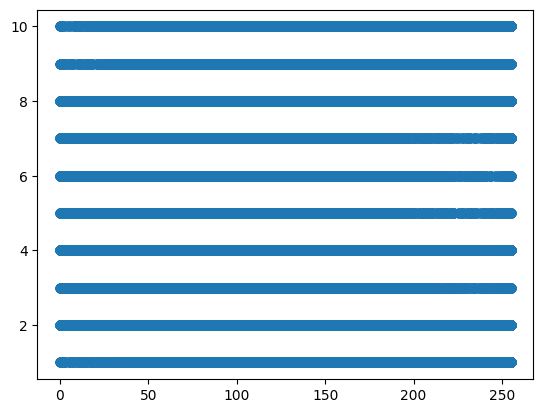

In [116]:
plt.scatter(data.Feature_1,data.class_label)
plt.show()

In [117]:
data = np.array(data)

In [118]:
def load_data(l):
    dataset = pd.read_csv(l)
    x_data = dataset.values[:, 1:-2]
    y_data = dataset.values[:, -1].reshape(-1, 1)
    return x_data, y_data
X, Y = load_data('/content/drive/MyDrive/nn_train (1).csv')

In [119]:
def normalise(X):
    return X / X.max()

X_normalised = normalise(X)

In [120]:
X.max() , X_normalised.max()

(255, 1.0)

In [121]:
#train and cross-validation split
def split(X,Y,s):
    m=X.shape[0]
    a=np.ceil(s*m).astype(int)
    return(X[:a],Y[:a],X[a:],Y[a:])

X_train,Y_train,X_cv,Y_cv = split(X_normalised,Y,0.8)

In [122]:
X_train.shape, Y_train.shape

((64000, 1024), (64000, 1))

In [123]:
X_cv.shape,Y_cv.shape

((16000, 1024), (16000, 1))

In [124]:
#one hot encoding the multiclass labels
def onehotencode(Y,num_classes):
    Y = Y.flatten()
    m = Y.shape[0]
    Y_n = np.zeros((m,num_classes))
    for k in range(num_classes):
        Y_n[:,k] = np.where(Y == k, 1, 0)
    return Y_n

In [125]:
#initialising the weights and biases
def initialise(layers):
    L = len(layers)
    W,b = {}, {}
    for l in range(1, L):
        W[f"W{l}"] = np.random.randn(layers[l - 1], layers[l]) * np.sqrt(2 / layers[l - 1])
        b[f"b{l}"] = np.zeros((1, layers[l]))
    return W, b

In [126]:
A0 = X_train.shape[1]
#---------A0,A1,A2
Layers = [A0,128,10]
W, b = initialise(Layers)

In [127]:
for weight, bias in zip(W.keys() , b.keys()):
    print(f"Shape of {weight} : {W[weight].shape} | Shape of {bias} : {b[bias].shape}")

Shape of W1 : (1024, 128) | Shape of b1 : (1, 128)
Shape of W2 : (128, 10) | Shape of b2 : (1, 10)


In [128]:
def loss(y_true, y_pred):
    m = y_true.shape[0]
    loss = (-1 / m) * np.sum(y_true * np.log(y_pred + 1e-20))
    return loss

In [129]:
def forward_prop(X, W, b, layers):
    activation = {}
    activation[f"A{0}"] = X
    for l in range(1,len(layers)):
        z = np.dot(activation[f"A{l-1}"] , W[f"W{l}"]) + b[f"b{l}"]
        if l == len(layers) - 1:
            exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
            out = exp_z / np.sum(exp_z, axis=1, keepdims=True)  #Softmax activation
        else:
            out = np.maximum(0, z)      #ReLU activation
        activation[f"A{l}"] = out
    return out, activation

In [130]:
y_pred, activation = forward_prop(X_train, W, b, Layers)

In [131]:
for a in activation.keys():
    print(f"Shape of {a} : {activation[a].shape}")

if y_pred is activation['A2'] and X_train is activation['A0'] :
    print("correct implementation of forward propagation")

Shape of A0 : (64000, 1024)
Shape of A1 : (64000, 128)
Shape of A2 : (64000, 10)
correct implementation of forward propagation


In [132]:
Y_bin = onehotencode(Y_train,Layers[-1])

In [133]:
def backward_prop(X, Y_bin, y_pred, activation, W, layers):
    m, n = Y_bin.shape
    grads = {}
    for i in reversed(range(1,len(layers))):
        if i == len(layers) - 1:
            dz = y_pred - Y_bin       #softmax derivative
        else:
            dz = (grads[f"dA{i+1}"] @ W[f"W{i+1}"].T) * np.where(activation[f"A{i}"] > 0, 1, 0)        #ReLU derivative
        grads[f"dA{i}"] = dz
        grads[f"dW{i}"] = (1 / m) * (activation[f"A{i-1}"].T @ dz)
        grads[f"db{i}"] = (1 / m) * np.sum(dz, axis=0,keepdims=True)
    return grads

In [134]:
grads = backward_prop(X_train, Y_bin, y_pred, activation, W, Layers)

In [135]:
for grad in grads.keys():
    print(f"Shape of {grad} : {grads[grad].shape}")

Shape of dA2 : (64000, 10)
Shape of dW2 : (128, 10)
Shape of db2 : (1, 10)
Shape of dA1 : (64000, 128)
Shape of dW1 : (1024, 128)
Shape of db1 : (1, 128)


In [136]:
def train(X, Y, W, b, layers, alpha, epochs):
    cost, iterations = [],[]
    Y_bin = onehotencode(Y,10)
    for i in range(epochs):
        y_pred, activations = forward_prop(X, W, b, layers)
        grads = backward_prop(X, Y_bin, y_pred, activations, W, layers)

        #gradient descent
        for k in range(1,len(layers)):
            W[f"W{k}"] -= alpha * grads[f"dW{k}"]
            b[f"b{k}"] -= alpha * grads[f"db{k}"]

        #loss calculation
        cst = loss(Y_bin, y_pred)
        cost.append(cst)
        iterations.append(i)
        if i % math.ceil(epochs / 10) == 0:
            print(f"Iteration {i:9d}, Cost: {cst}")
    return W, b, cost, iterations

In [137]:
alpha = 0.01
epochs = 100
print(f"units = {Layers} alpha = {alpha} layers = {2} epochs = {epochs}")
W,b, loss_list, _ = train(X_train, Y_train, W, b, Layers, alpha, epochs)

units = [1024, 128, 10] alpha = 0.01 layers = 2 epochs = 100
Iteration         0, Cost: 2.233207479440836
Iteration        10, Cost: 2.040651327836795
Iteration        20, Cost: 2.0099629399107295
Iteration        30, Cost: 1.9908421070100593
Iteration        40, Cost: 1.9761801446088334
Iteration        50, Cost: 1.9638662164662766
Iteration        60, Cost: 1.9528195358820117
Iteration        70, Cost: 1.9426754505676511
Iteration        80, Cost: 1.9333320986274958
Iteration        90, Cost: 1.9247642252713644


In [138]:
def predict(X, W, b, layers):
    z,_ = forward_prop(X, W, b, layers)
    predictions = np.argmax(z, axis=1)
    return predictions

In [139]:
def f1_score(classes, y_train,y_predicted):
    con_matrix = np.zeros((classes,classes),dtype=int)
    for i, k in zip(y_train, y_predicted):
        con_matrix[int(i),int(k)] += 1
    df = pd.DataFrame(con_matrix)
    precision = np.zeros(classes)
    recall = np.zeros(classes)
    f1 = np.zeros(classes)
    for i in range(classes):
        t_p = con_matrix[i, i]
        f_p = np.sum(con_matrix[:, i]) - t_p
        f_n = np.sum(con_matrix[i, :]) - t_p
        precision[i] = t_p / (t_p + f_p) if (t_p + f_p) != 0 else 0
        recall[i] = t_p / (t_p + f_n) if (t_p + f_n) != 0 else 0
        f1[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i]) if (precision[i] + recall[i]) != 0 else 0
    f1score = np.mean(f1)
    return f1score, df

In [140]:
def plot(cost,i_list):
    plt.plot(i_list,cost,c="r",label="cost")
    plt.xlabel(f"iteration")
    plt.ylabel("cost")
    plt.legend()
    plt.show()

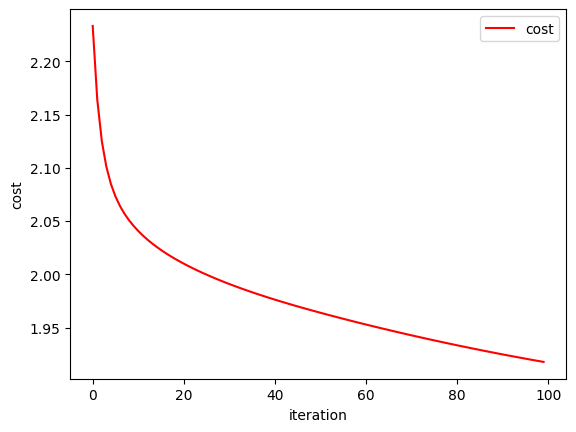

In [141]:
plot(loss_list,_)

In [143]:
accuracy = np.mean(y_pred == Y_cv)
f1, confusion_matrix = f1_score(units[-1], Y_cv, y_pred)
print(f"Accuracy: {accuracy*100:.7f}%, F1 Score: {f1:.2f}")
print()
print("confusion_matrix")
confusion_matrix

ValueError: operands could not be broadcast together with shapes (64000,10) (16000,1) 